In [17]:
import geopandas as gpd
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance

## Preprocess buildings

In [18]:
buildings = gpd.read_parquet("/data/uscuni-ulce/boundaries_of_change/classification/")

Remap clusters

In [19]:
final_clusters = pd.read_parquet(
    "/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v3.pq"
)
final_clusters

,1,2,3,4,5,6
7,,,,,,
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,2
4,1,1,1,1,1,2
5,1,1,1,1,2,3
...,...,...,...,...,...,...
104,2,4,8,16,31,59
105,2,4,8,16,31,59
106,2,4,8,16,32,60


In [20]:
level_columns = []

In [21]:
for level in final_clusters.columns:
    buildings[f"level_{level}"] = buildings.final_without_noise.map(
        final_clusters[level]
    )
    level_columns.append(f"level_{level}")

buildings = buildings.rename(columns={"final_without_noise":"level_7"})
level_columns.append("level_7")

In [22]:
buildings.head()

,geometry,level_7,area,level_1,level_2,level_3,level_4,level_5,level_6
__null_dask_index__,,,,,,,,,
0,POINT (4099683.344 3108236.287),50,66.767646,1,2,4,8,16,30
1,POINT (4100189.13 3108803.392),1,427.019080,1,1,1,1,1,1
2,POINT (4100069.189 3109146.3),1,144.324859,1,1,1,1,1,1
3,POINT (4100144.944 3108299.666),1,139.581363,1,1,1,1,1,1
4,POINT (4100022.946 3108688.179),1,41.651016,1,1,1,1,1,1


In [23]:
gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg")

,name,geometry_type
0,1240_mongol_invasion,Polygon
1,900_political,Polygon
2,1000_political,Polygon
3,1300_ostsiedlung,Polygon
4,1550_religion,Polygon
5,1526_political,Polygon
6,1618_political,Polygon
7,1648_political,Polygon
8,1600_religion,Polygon
9,1812_political,Polygon


In [24]:
boundary_list = list(gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg").name)

<Axes: >

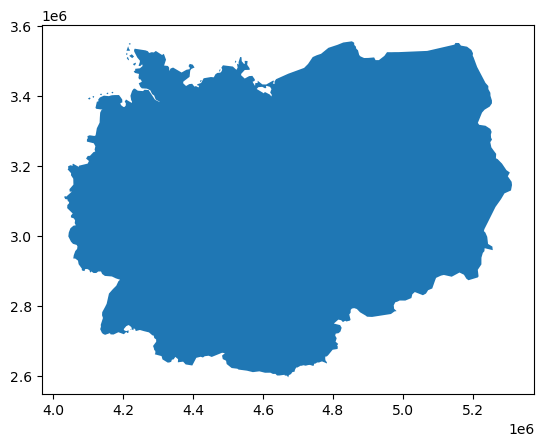

In [25]:
aoi = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
aoi = aoi.dissolve()
aoi.plot()

In [26]:
def get_building_counts_per_region(buildings, boundary, level="level_4"):
    joined = gpd.sjoin(buildings, boundary, how="left", predicate="within")
    grouped = joined.groupby("NAME")[level].value_counts()
    cnt_table = pd.DataFrame(grouped.unstack().fillna(0).T)
    
    return cnt_table

In [27]:
def normalize_building_counts(count_table):
    region_building_sums = count_table.sum(axis=0)
    cnt_table_norm = count_table.div(region_building_sums, axis=1)
    return cnt_table_norm

In [28]:
def generate_bc_heatmaps_for_boundary(level_list, boundary_name):

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()
    
    for level, ax in zip(level_list, axs):
        bc = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{boundary_name}_{level}.pq')
        sns.heatmap(bc, annot=True, ax=ax)
        ax.set_title(level)

    fig.suptitle(boundary_name)
    fig.tight_layout()

Outliers on rows 3,4,10 on level 4

In [29]:
def compute_bc_matrix(count_table):
    num_regions = len(count_table.columns)
    bray_curtis_matrix = np.zeros((num_regions, num_regions))

    for i in range(num_regions):
        for j in range(num_regions):
            if i != j:
                reg_i = count_table.iloc[:,i]
                reg_j = count_table.iloc[:,j]
                bray_curtis_matrix[i,j] = distance.braycurtis(reg_i, reg_j)

    bray_curtis_matrix = pd.DataFrame(bray_curtis_matrix, index=count_table.columns, columns=count_table.columns)
    return bray_curtis_matrix

In [30]:
def generate_bc_matrices(boundary_list, level_list):
    for bnd in boundary_list:
        boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
        
        for level in level_list:
            building_counts = get_building_counts_per_region(buildings, boundary, level)
            building_counts_norm = normalize_building_counts(building_counts)
            
            bray_curtis_matrix = compute_bc_matrix(building_counts_norm)
    
            bray_curtis_matrix.to_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{bnd}_{level}.pq')

In [35]:
def generate_boundary_diagram(boundary_list):
    fig, ax = plt.subplots(figsize=(15,15))
    aoi.plot(ax=ax, color='lightgray')
    
    for bnd in boundary_list:
        boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
        bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{bnd}_level_4.pq')

        indices = boundary.sindex.query(boundary.geometry, predicate="intersects")
        left, right = np.unique(np.sort(indices, axis=0), axis=1)

        mask = left == right
        left = left[~mask]
        right = right[~mask]
        geoms = boundary.iloc[left].intersection(boundary.iloc[right], align=False)
        left = boundary.NAME.iloc[left]
        right = boundary.NAME.iloc[right]

        border_widths = []

        for l, r in zip(left, right):
            border_widths.append(bray_curtis_matrix.loc[l, r])

        geoms["width"] = [np.sqrt(w) for w in border_widths]
        print(geoms["width"])
        widths = (geoms.width - np.min(geoms.width)) / (np.max(geoms.width) - np.min(geoms.width.min))
        geoms["map_width"] = widths

        geoms.plot(ax=ax, linewidth=geoms["map_width"], color='red')

[np.float64(0.47046710795425584), np.float64(0.6447104081279669), np.float64(0.48284256836710626), np.float64(0.4922169436737944), np.float64(0.7755044324354624), np.float64(0.7700697555522001), np.float64(0.33804198608206354), np.float64(0.805961120875545), np.float64(0.5026313293966833)]


AttributeError: 'list' object has no attribute 'min'

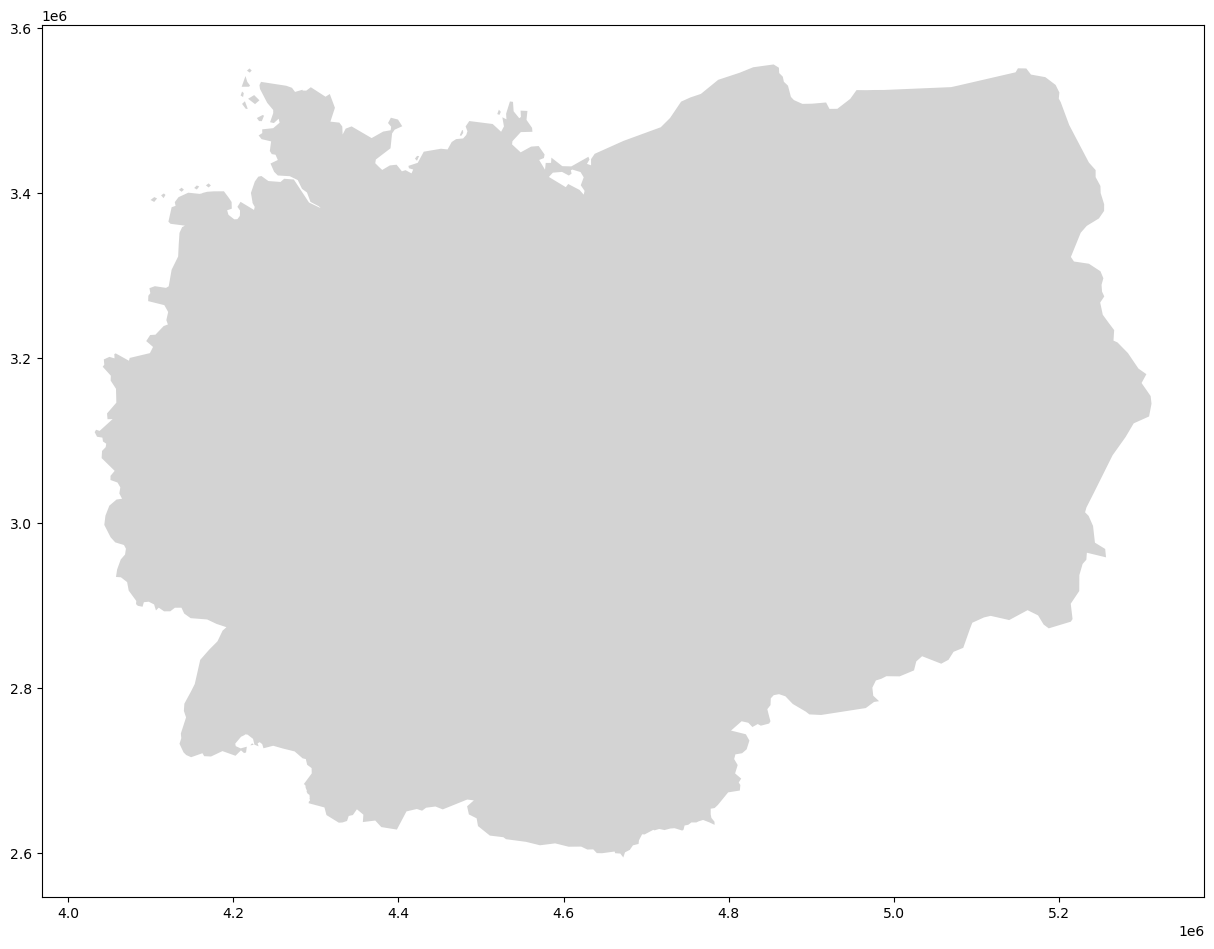

In [36]:
generate_boundary_diagram(boundary_list)

## Bray-Curtis

In [68]:
bray_curtis_matrix =compute_bc_matrix(cnt_table_norm)

<Axes: xlabel='NAME', ylabel='NAME'>

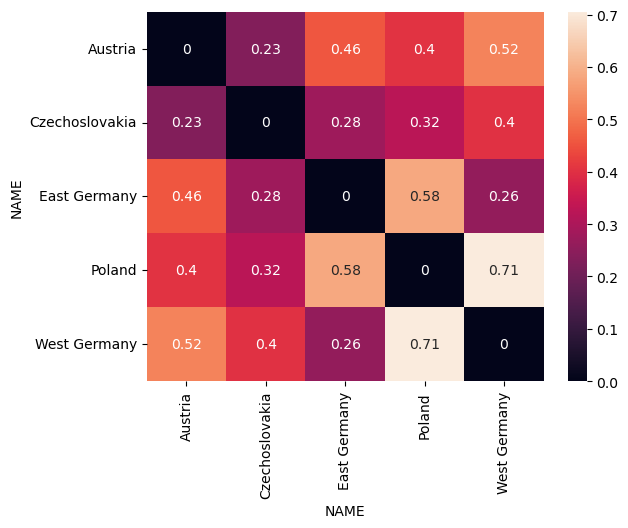

In [70]:
sns.heatmap(bray_curtis_matrix, annot=True)

In [12]:
generate_bc_matrices(boundary_list, level_columns)

## Draw borders

In [ ]:
for bnd in boundary_list:
    boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
    joined = gpd.sjoin(buildings, boundary, how="left", predicate="within")
    generate_bc_heatmaps_for_boundary(level_columns, bnd)

[np.float64(0.47046710795425584), np.float64(0.6447104081279669), np.float64(0.48284256836710626), np.float64(0.4922169436737944), np.float64(0.7755044324354624), np.float64(0.7700697555522001), np.float64(0.33804198608206354), np.float64(0.805961120875545), np.float64(0.5026313293966833)]


NameError: name 'mp' is not defined

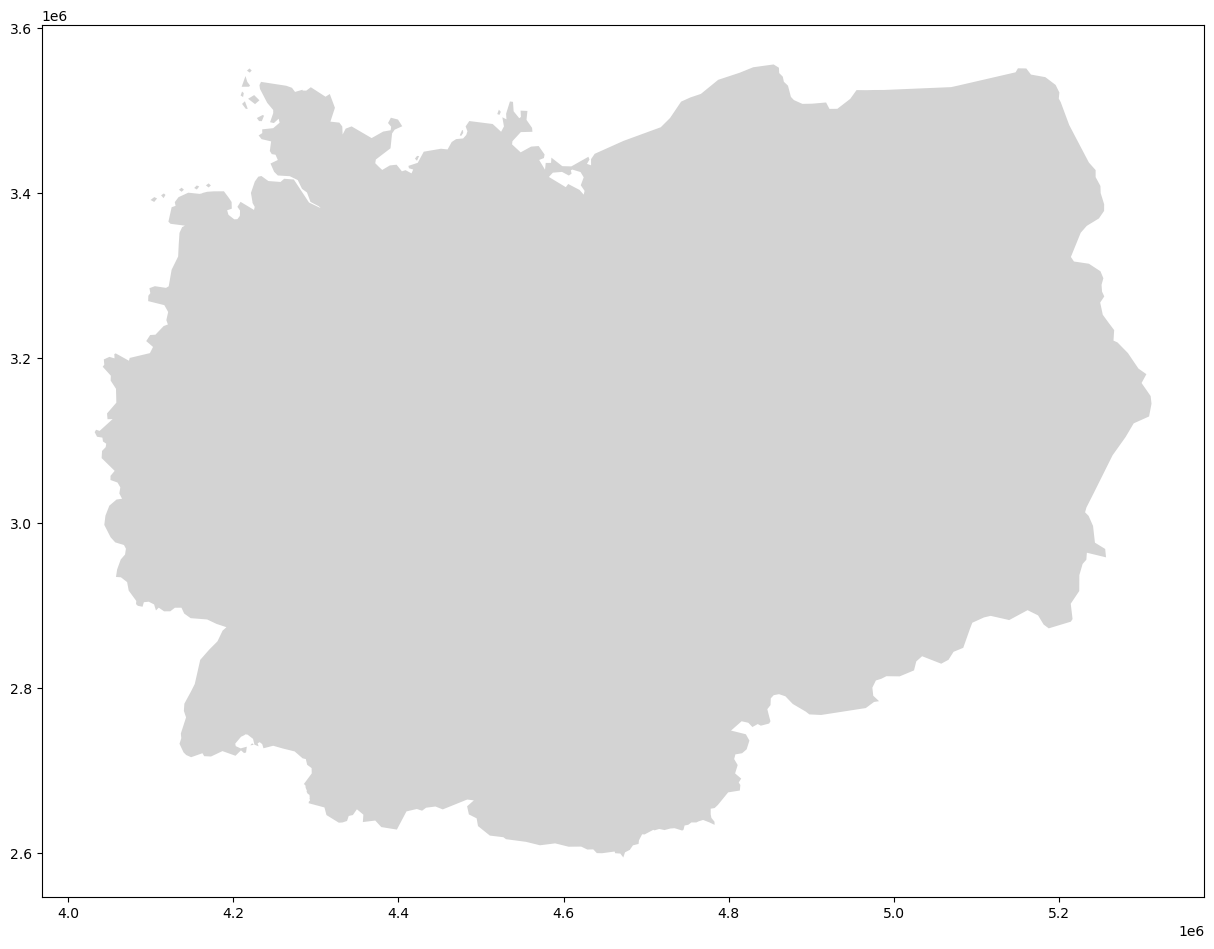

<Axes: >

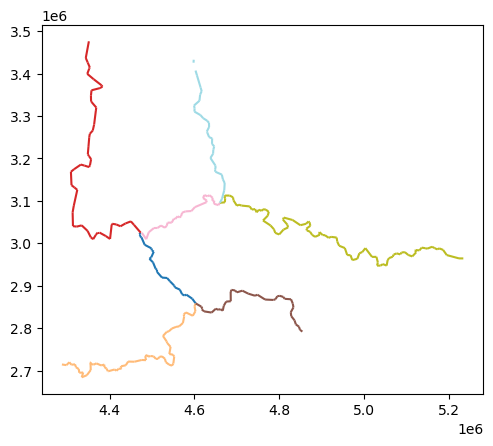

In [78]:
indices = boundaries.sindex.query(boundaries.geometry, predicate="intersects")
left, right = np.unique(np.sort(indices, axis=0), axis=1)

mask = left == right
left = left[~mask]
right = right[~mask]
geoms = boundaries.iloc[left].intersection(boundaries.iloc[right], align=False)
left = boundaries.NAME.iloc[left]
right = boundaries.NAME.iloc[right]

geoms.plot(cmap='tab20')

In [96]:
geoms

0    MULTILINESTRING ((4470617.452 3025026.023, 447...
0    MULTILINESTRING ((4603174.085 2858273.123, 460...
0    MULTILINESTRING ((4351305.316 3476171.174, 434...
1    MULTILINESTRING ((4854633.284 2791782.465, 484...
1    MULTILINESTRING ((4630531.409 3110893.427, 463...
1    MULTILINESTRING ((4660255.78 3095529.129, 4671...
3    MULTILINESTRING ((4598483.274 3432717.975, 459...
dtype: geometry

In [86]:
bray_curtis_matrix.loc[left.iloc[0],right.iloc[0]]

np.float64(0.4004353322329587)

In [99]:
geoms = gpd.GeoDataFrame(geometry=geoms)

In [100]:
border_widths = []

for l, r in zip(left, right):
    border_widths.append(bray_curtis_matrix.loc[l, r])


In [102]:
geoms["width"] = [np.sqrt(w) for w in border_widths]
geoms

,geometry,width
0,"MULTILINESTRING ((4470617.452 3025026.023, 447...",0.632800
0,"MULTILINESTRING ((4603174.085 2858273.123, 460...",0.723634
0,"MULTILINESTRING ((4351305.316 3476171.174, 434...",0.509238
1,"MULTILINESTRING ((4854633.284 2791782.465, 484...",0.481348
1,"MULTILINESTRING ((4630531.409 3110893.427, 463...",0.526727
1,"MULTILINESTRING ((4660255.78 3095529.129, 4671...",0.568459
3,"MULTILINESTRING ((4598483.274 3432717.975, 459...",0.763765


In [109]:
widths = (geoms.width - geoms.width.min()) / (geoms.width.max() - geoms.width.min())

geoms["map_width"] = widths
geoms

,geometry,width,map_width
0,"MULTILINESTRING ((4470617.452 3025026.023, 447...",0.632800,0.536269
0,"MULTILINESTRING ((4603174.085 2858273.123, 460...",0.723634,0.857901
0,"MULTILINESTRING ((4351305.316 3476171.174, 434...",0.509238,0.098755
1,"MULTILINESTRING ((4854633.284 2791782.465, 484...",0.481348,0.000000
1,"MULTILINESTRING ((4630531.409 3110893.427, 463...",0.526727,0.160682
1,"MULTILINESTRING ((4660255.78 3095529.129, 4671...",0.568459,0.308447
3,"MULTILINESTRING ((4598483.274 3432717.975, 459...",0.763765,1.000000


<Axes: >

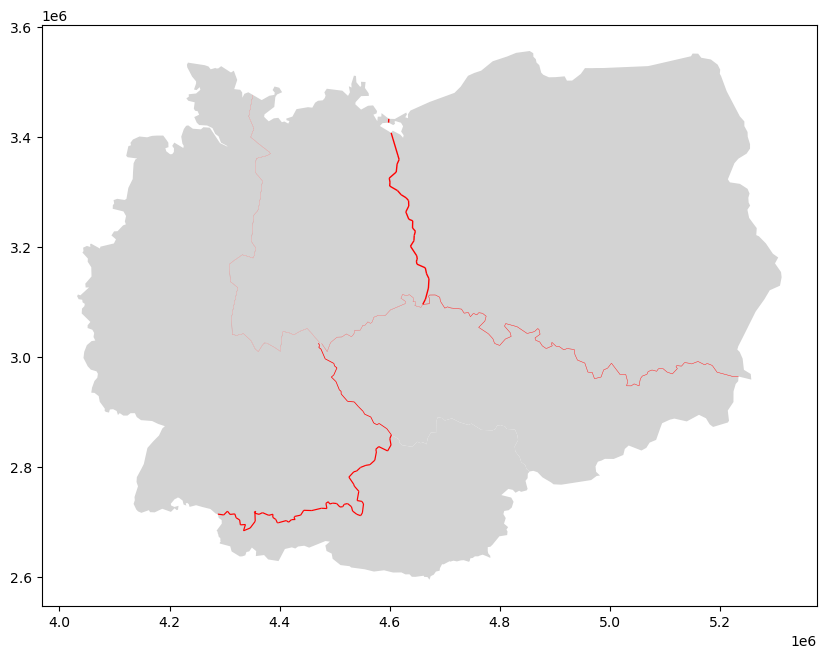

In [110]:
fig, ax = plt.subplots(figsize=(10,10))
aoi.plot(ax=ax, color='lightgray')

geoms.plot(ax=ax, linewidth=geoms["map_width"], color='red')

## Principal Coordinates visualization

In [24]:
from skbio.stats.ordination import pcoa
from skbio.stats.distance import DistanceMatrix

In [25]:
pcoa_res = pcoa(DistanceMatrix(bray_curtis_matrix, ids=cnt_table_norm.columns))

In [26]:
pcoa_res_df = pd.DataFrame(pcoa_res.samples.iloc[:, :2], index=cnt_table_norm.columns)

In [27]:
pcoa_res_df

,PC1,PC2
NAME,,
Austria,-0.131978,0.210060
Czechoslovakia,-0.051598,-0.013323
East Germany,0.205911,-0.085319
Poland,-0.357217,-0.118359
West Germany,0.334882,0.006941


<Axes: xlabel='PC1', ylabel='PC2'>

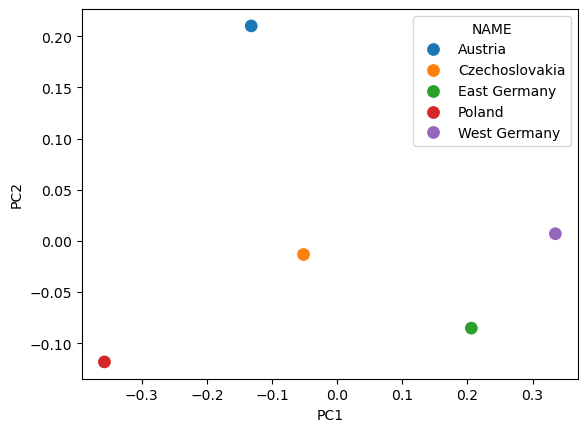

In [28]:
sns.scatterplot(x="PC1", y="PC2", hue=pcoa_res_df.index, data=pcoa_res_df, s=100)